## DNN 기반 이진분류 모델 구현
- 데이터셋 : iris.scv
- 피쳐 : 4개
- 타겟 : variety [setosa와 나머지]
- 학습방법 : 지도학습 - 분류 - 이진분류
- 알고리즘 : 인공신경망(ANN) => MLP, DNN : 은닉층이 많은 구성
- 프레임워크 : pytorch

In [50]:
# 모델 관련 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchmetrics.classification import F1Score, BinaryF1Score
from torchmetrics.classification import BinaryConfusionMatrix
from torchinfo import summary

# Data 관련 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [51]:
# 활용 패키지 버전 체크 => 사용자 정의 함수로 구현하기
print(f'Pytorch V. {torch.__version__}')
print(f'Pandas V. {torch.__version__}')

Pytorch V. 2.4.1
Pandas V. 2.4.1


In [52]:
# 데이터 로딩
FILE_PATH='../data/iris.csv'

# CSV => DataFrame
irisDF=pd.read_csv(FILE_PATH)

# 데이터 확인
irisDF.head(3)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa


In [53]:
# 타겟 변경 => 정수화, 클래스 3개 => 2개
irisDF['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [54]:
irisDF['variety'] =(irisDF['variety'] =='Setosa')
irisDF['variety'] = irisDF['variety'].astype('int')

In [55]:
print(f'고유값 : {irisDF["variety"].unique()}')
irisDF.head()

고유값 : [1 0]


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


[2] 모델 클래스 설계 및 정의<hr>
- 클래스목적 : iris 데이터를 학습 및 추론 목적 
- 클래스이름 : IrisBCFModel
- 부모클래스 : nn.Module
- 매개변수 : 층별 입출력 개수 고정하기때문에 필요 없음
- 속성필드 : 
- 기능역할 : __init__() : 모델 구조, forward() : 순방향 학습 <= 오버라이딩
- 클래스구조
    * 입력층 : 입력  4개(피처)  출력 10개(퍼셉트론/뉴런 10개 존재)
    * 은닉층 : 입력 10개        출력 5개(퍼셉트론/뉴런 5개 존재)
    * 출력층 : 입력  5개        출력 1개(퍼셉트론/뉴런 1개 존재 : 2진분류)

- 활성화함수
    * 클래스형태 => nn.MESLoss, nn.ReLU => __init__() 메서드
    * 함수형태 => torch.nn.fuctional 아래에 => forward() 메서드

In [56]:
class IrisBCFModel(nn.Module): # 이진분류

    def __init__(self):
        super().__init__() # 부모

        self.in_layer = nn.Linear(4,10) #입력층
        self.h_layer = nn.Linear(10,5) #은닉층
        self.out_layer = nn.Linear(5,1) #출력층

    # 순방향 학습 진행 메서드
    def forward(self, x):
        y=F.relu(self.in_layer(x))
        y=F.relu(self.h_layer(y))
        return F.sigmoid(self.out_layer(y)) # 2진 분류는 출력층이 시그모이드

In [57]:
# 모델 인스턴스 생성
model=IrisBCFModel()

print(model)

IrisBCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (h_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=1, bias=True)
)


In [58]:
# 모델 사용 메모리 정보 확인
summary(model, input_size=(1000,4)) #첫번째는 입력데이터수, 두번째는 피쳐수

Layer (type:depth-idx)                   Output Shape              Param #
IrisBCFModel                             [1000, 1]                 --
├─Linear: 1-1                            [1000, 10]                50
├─Linear: 1-2                            [1000, 5]                 55
├─Linear: 1-3                            [1000, 1]                 6
Total params: 111
Trainable params: 111
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.02
Forward/backward pass size (MB): 0.13
Params size (MB): 0.00
Estimated Total Size (MB): 0.14

[3] 데이터셋 클래스 설계 및 정의<hr>
- 데이터셋 : iris.csv
- 피쳐개수 : 4개
- 타겟개수 : 1개
- 클래스이름 : IrisDataset
- 부모클래스 : utils.data.Dataset
- 속성필드 : featureDF, targetDF, n_rows, n_features
- 필수메서드
    * __init__(self) : 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정
    * __len__(self) : 데이터의 개수 반환
    * __getitem__(self, index) : 특정 인덱스의 피쳐와 타겟 반환

In [59]:
class IrisDataset(Dataset):

    def __init__(self, featureDF, targetDF):
        self.featureDF=featureDF
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_features=featureDF.shape[1]

    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
        # 넘파이를 텐서로
        featureTS=torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS=torch.FloatTensor(self.targetDF.iloc[index].values)        
        # 피쳐와 타겟 반환
        return featureTS, targetTS

In [60]:
# 피쳐, 타겟 추출
featureDF, targetDF=irisDF[irisDF.columns[:-1]], irisDF[irisDF.columns[-1:]]
print(f'featureDF => {featureDF.shape}, targetDF => {targetDF.shape}')

# 데이터셋 인스턴스 생성
irisDS=IrisDataset(featureDF, targetDF)

featureDF => (150, 4), targetDF => (150, 1)


[4] 학습 준비
- 학습 횟수 : EPOCH <= 처음부터 끝까지 학습하는 단위
- 배치 크기 : BATCH_SIZE <= 한번에 학습할 데이터셋 양
- 위치 지정 : DEVICE <= 텐서 저장 및 실행 위치 (GPU/CPU)
- 학습률 : LR 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001~0.1

In [61]:
# 학습 진행 관련 설정
EPOCH=1000
BATCH_SIZE=10
BATCH_CNT=irisDF.shape[0]/BATCH_SIZE
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
LR=0.001

- 인스턴스/객체 : 모델, 데이터셋, 최적화 (+ 손실함수, 성능지표)

In [62]:
# 모델 인스턴스
model=IrisBCFModel()

# 데이터셋 인스턴스

# 학습용, 검증용, 테스트용 데이터 분리
X_train, X_test, y_train, y_test=train_test_split(featureDF, targetDF, random_state=1)
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, random_state=1)
print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')

trainDS=IrisDataset(X_train, y_train)
valDS=IrisDataset(X_val, y_val)
testDS=IrisDataset(X_test, y_test)

# 데이터로드 인스턴스
trainDL=DataLoader(trainDS, batch_size=BATCH_SIZE)

(84, 4) (38, 4) (28, 4)
(84, 1) (38, 1) (28, 1)


In [63]:
# 최적화 인스턴스 => W, b 텐서 즉, model.parameters() 전달
optimizer=optim.Adam(model.parameters(),lr=LR)

# 손실함수 인스턴스 => 분류 => 이진분류 BinaryCrossEntropyLoss => BCELoss
#                            예측값은 확률값으로 전달 => sigmoid() AF 처리 후 전달
bceLoss=nn.BCELoss()

In [64]:
# 학습의 효과 확인 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTROY=[[],[]], [[],[]]

for epoch in range(1,EPOCH+1):
    # 학습 모드로 모델 설정
    model.train()

    # 배치크기 만큼 데이터 로딩해서 학습 진행
    loss_total, score_total=0, 0
    for featureTS, targetTS in trainDL:

        # 학습 진행
        pre_y=model(featureTS)

        # 손실 계산
        loss=bceLoss(pre_y, targetTS)
        loss_total += loss.item()

        # 성능평가 계산
        score=F1Score(task='binary')(pre_y, targetTS)
        score_total += score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 에포크 당 검증기능
    # 모델 검증 모드 설정
    model.eval()
    with torch.no_grad():
        # 검증 데이터셋
        val_featureTS=torch.FloatTensor(valDS.featureDF.values)
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)

        # 추론/평가
        pre_val=model(val_featureTS)

        # 손실
        loss_val=bceLoss(pre_val, val_targetTS)

        # 성능평가
        score_val=F1Score(task='binary')(pre_val, val_targetTS)
    
    # 에포크 당 손실값과 성능평가값 저장
    LOSS_HISTORY[0].append(loss_total/BATCH_CNT)
    SCORE_HISTROY[0].append(score_total/BATCH_CNT)

    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTROY[1].append(score_val)

    print(f'[{epoch}/{EPOCH}]\n- [TRAIN] LOSS : {LOSS_HISTORY[0][-1]} [SCORE] : {SCORE_HISTROY[0][-1]}')
    print(f'[{epoch}/{EPOCH}]\n- [VAL] LOSS : {LOSS_HISTORY[1][-1]} [SCORE] : {SCORE_HISTROY[1][-1]}')

[1/1000]
- [TRAIN] LOSS : 0.4482939759890238 [SCORE] : 0.26263071099917096
[1/1000]
- [VAL] LOSS : 0.6894301772117615 [SCORE] : 0.6000000238418579
[2/1000]
- [TRAIN] LOSS : 0.4291562000910441 [SCORE] : 0.26263071099917096
[2/1000]
- [VAL] LOSS : 0.6760192513465881 [SCORE] : 0.6000000238418579
[3/1000]
- [TRAIN] LOSS : 0.41556172370910643 [SCORE] : 0.26263071099917096
[3/1000]
- [VAL] LOSS : 0.666265070438385 [SCORE] : 0.6486486196517944
[4/1000]
- [TRAIN] LOSS : 0.40386046171188356 [SCORE] : 0.40484330654144285
[4/1000]
- [VAL] LOSS : 0.6561342477798462 [SCORE] : 1.0
[5/1000]
- [TRAIN] LOSS : 0.3924932718276978 [SCORE] : 0.6
[5/1000]
- [VAL] LOSS : 0.6458105444908142 [SCORE] : 1.0
[6/1000]
- [TRAIN] LOSS : 0.381380025545756 [SCORE] : 0.4446560879548391
[6/1000]
- [VAL] LOSS : 0.6356163620948792 [SCORE] : 0.1538461595773697
[7/1000]
- [TRAIN] LOSS : 0.37059656778971356 [SCORE] : 0.03333333333333333
[7/1000]
- [VAL] LOSS : 0.6258201599121094 [SCORE] : 0.0
[8/1000]
- [TRAIN] LOSS : 0.3604

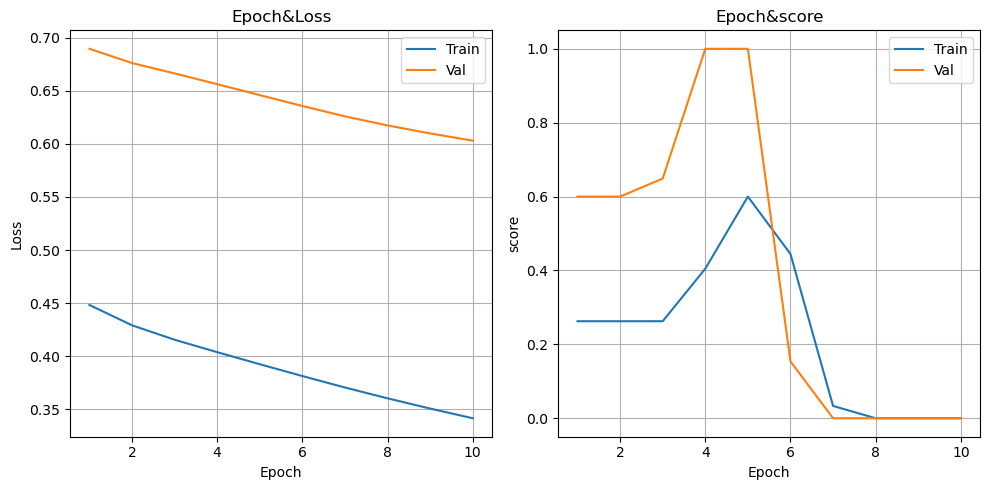

In [65]:
# 학습 후 loss 시각화

THRESHOLD=10
fg, axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1, THRESHOLD+1), LOSS_HISTORY[0][:THRESHOLD], label='Train')
axes[0].plot(range(1, THRESHOLD+1), LOSS_HISTORY[1][:THRESHOLD], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Epoch&Loss')

axes[1].plot(range(1, THRESHOLD+1), SCORE_HISTROY[0][:THRESHOLD], label='Train')
axes[1].plot(range(1, THRESHOLD+1), SCORE_HISTROY[1][:THRESHOLD], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('score')
axes[1].set_title('Epoch&score')
plt.tight_layout()
plt.show()